In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.util as model_util
import model.mechint_net as mechint_net
import feature.experimental_dataset as experimental_dataset
import feature.util as feature_util
import train.train_model as train_model
import train.performance as performance
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logomaker
import scipy.signal
import scipy.special

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [3]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [4]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_ctcf_hepg2/mechint_net/1/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR607XFI_CTCF_HepG2/ENCFF664UGR_idrpeaks.bed.gz")

In [5]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_max_hepg2/mechint_net/1/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR168DYA_MAX_HepG2/ENCFF254ZDA_idrpeaks.bed.gz")

In [6]:
model_path = os.path.join(base_path, "models/trained_models/experimental/chipseq_foxa1_hepg2/mechint_net/3/last_ckpt.pth")
peaks_bed_path = os.path.join(base_path, "data/encode/chipseq/ENCSR865RXA_FOXA1_HepG2/ENCFF081USG_idrpeaks.bed.gz")

In [7]:
# model_path = os.path.join(base_path, "models/trained_models/experimental/dnase_hl60/mechint_net/1/last_ckpt.pth")
# peaks_bed_path = os.path.join(base_path, "data/encode/dnase/ENCSR889WKL_HL60/ENCFF773SFA_peaks.bed.gz")

### Show training curves

In [8]:
metrics_path = os.path.join(os.path.dirname(model_path), "metrics.json")
with open(metrics_path, "r") as f:
    metrics = json.load(f)

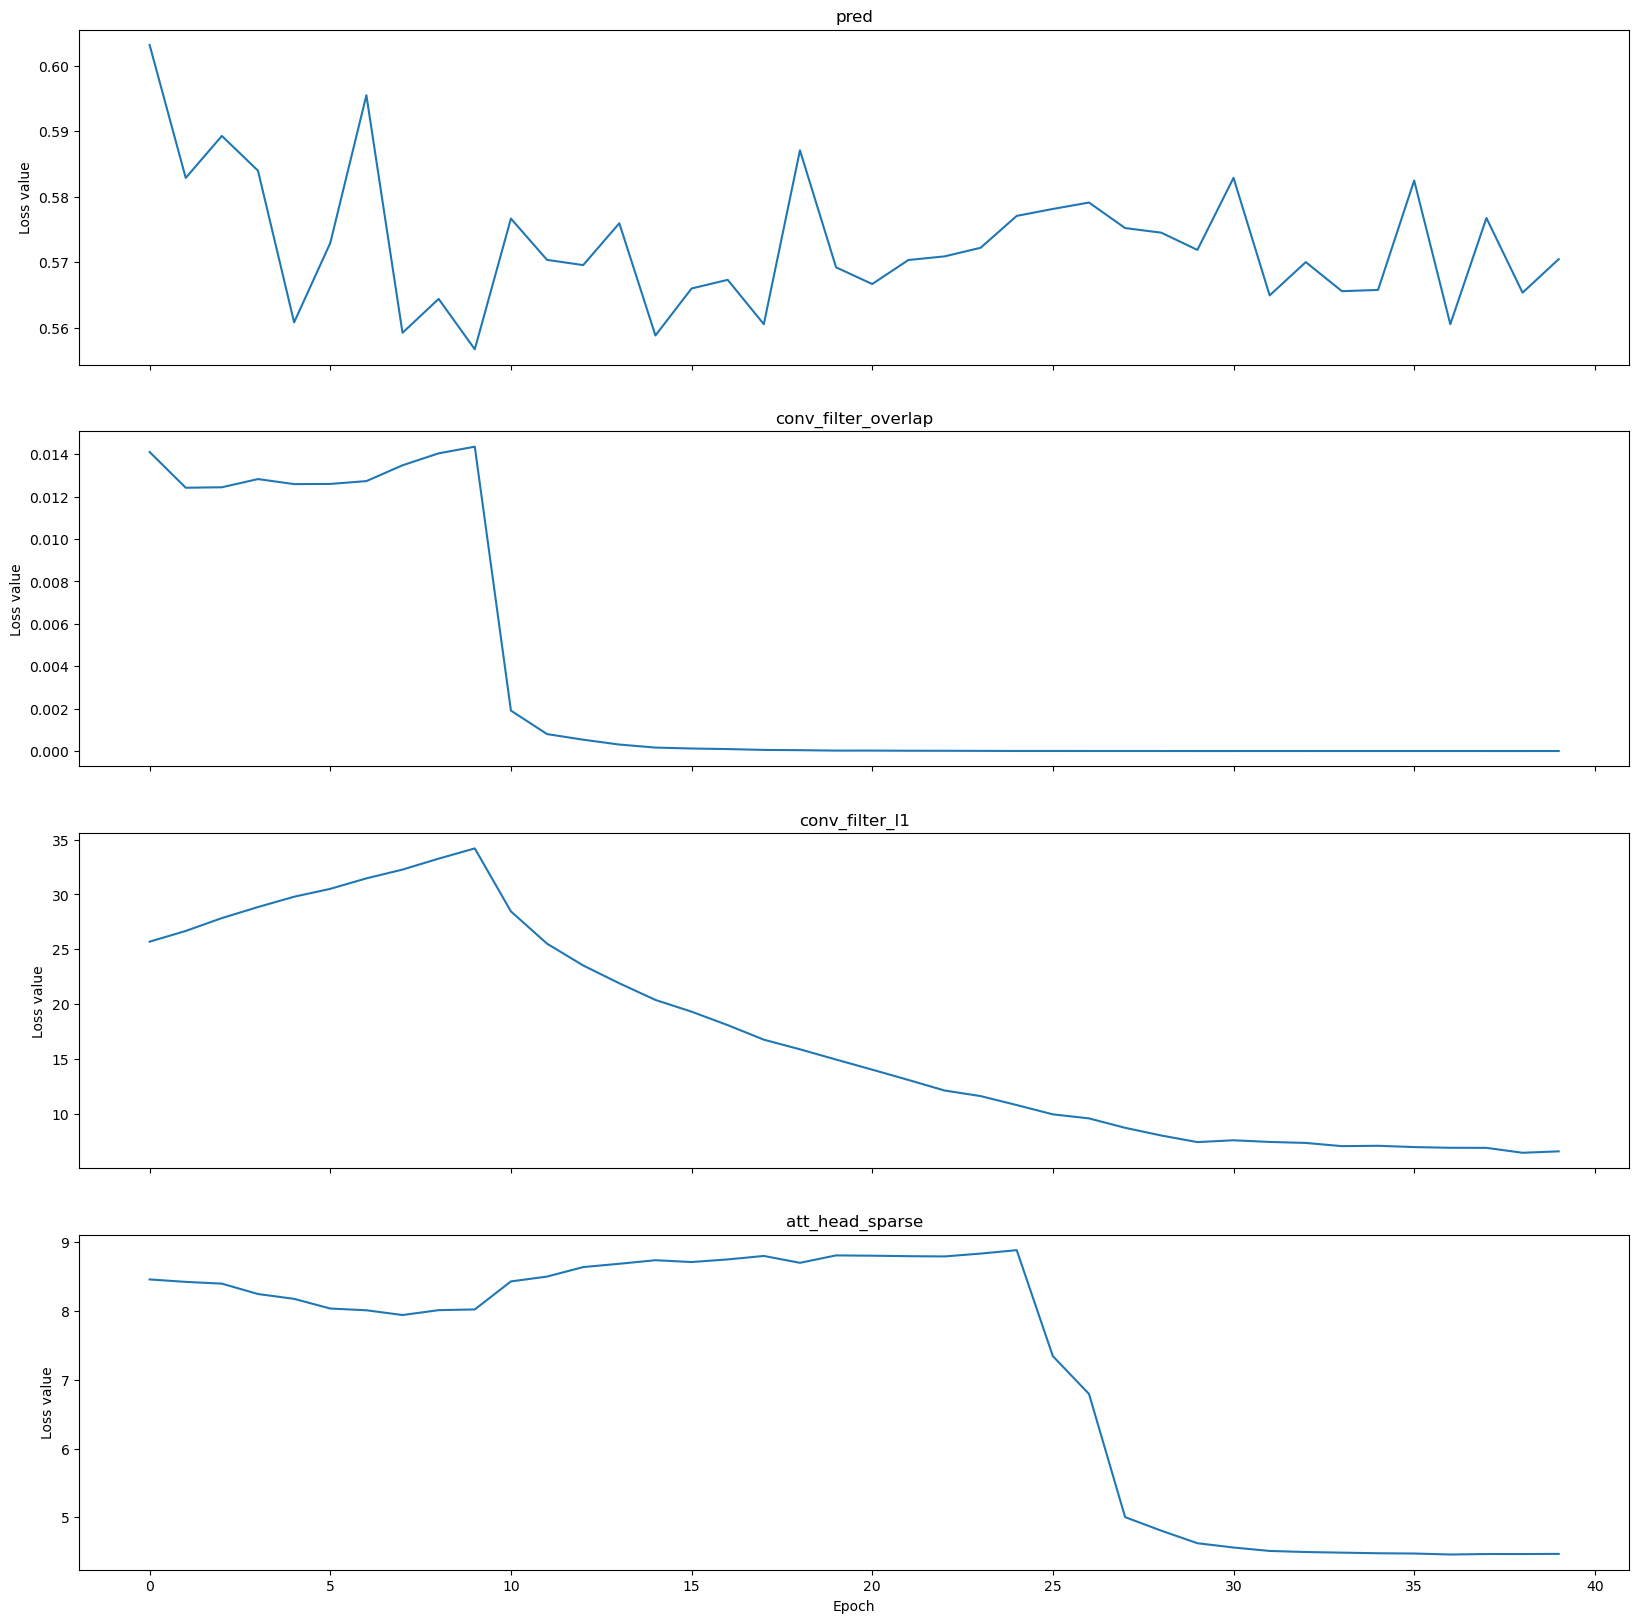

In [9]:
loss_comps = ["pred", "conv_filter_overlap", "conv_filter_l1", "att_head_sparse"]
loss_comp_vals = {
    loss_comp : metrics["val_epoch_loss_" + loss_comp]["values"] for loss_comp in loss_comps
}

fig, ax = plt.subplots(nrows=len(loss_comps), sharex=True, figsize=(20, 5 * len(loss_comps)))
for i, loss_comp in enumerate(loss_comps):
    vals = loss_comp_vals[loss_comp]
    ax[i].plot(np.arange(len(vals)), vals)
    ax[i].set_title(loss_comp)
    ax[i].set_ylabel("Loss value")
ax[-1].set_xlabel("Epoch")
plt.show()

### Import model and create data loader

In [10]:
model = model_util.load_model(
    mechint_net.MechIntRegNet, model_path
).to(DEVICE)

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
data_loader = experimental_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "peaks_bed_path": peaks_bed_path,
        "batch_size": 128,
        "chrom_set": ["chr1"]
    }
).result

data_loader.dataset.on_epoch_start()

### Run predictions

In [ ]:
losses_batched, losses, model_outputs, losses_comps, model_outputs_other, input_data = \
    train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)

In [ ]:
for key in losses_comps.keys():
    losses_comps[key] = losses_comps[key][:128]
for key in model_outputs_other.keys():
    model_outputs_other[key] = model_outputs_other[key][:128]
for i in range(len(input_data)):
    input_data[i] = input_data[i][:128]
model_outputs = model_outputs[:128]

In [ ]:
true_labels, pred_probs = np.squeeze(input_data[1], axis=1), np.squeeze(model_outputs, axis=1)

In [ ]:
for key, val in losses_comps.items():
    print("%s: %6.4f" % (key, np.mean(val)))

In [ ]:
conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
att_vals = model_outputs_other["att_vals"]  # Shape: N x AL x NH x L'

In [ ]:
# Extract convolutional filter weights
conv_weights = model.conv_layer.weight.detach().cpu().numpy()  # Shape: F x 4 x W

### Compute performance metrics

In [ ]:
metrics = performance.compute_performance_metrics(true_labels, pred_probs)
max_key_len = max(len(k) for k in metrics.keys())
for key, val in metrics.items():
    print("%s: %6.4f" % (key.ljust(max_key_len), val))

### Visualize convolutional filter weights

In [ ]:
def create_dna_logo(matrix, ax=None):
    """
    Creates a DNA logo using the logomaker package.
    Arguments:
        `matrix`: an L x 4 array of values to plot, in ACGT order
        `ax`: Axes object on which to plot
    Returns the resulting Logo object.
    """
    data = pd.DataFrame(matrix, columns=["A", "C", "G", "T"])
    logo = logomaker.Logo(data, ax=ax)
    return logo

In [ ]:
average_act_counts = np.mean(np.sum(conv_acts > 0, axis=1), axis=0)
num_cols = 2
num_rows = int(np.ceil(len(conv_weights) / 2))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
if len(ax.shape) == 1:
    ax = ax[None]

# Mean-center
conv_weights_centered = conv_weights - np.mean(conv_weights, axis=1, keepdims=True)

min_height = np.min(np.sum(np.minimum(conv_weights_centered, 0), axis=1))
max_height = np.max(np.sum(np.maximum(conv_weights_centered, 0), axis=1))
ylims = (min_height, max_height)
for filter_i in range(conv_weights.shape[0]):
    i, j = filter_i % num_rows, filter_i // num_rows
    
    weights = np.transpose(conv_weights_centered[filter_i])
    
    create_dna_logo(weights, ax=ax[i, j])
    ax[i, j].set_ylim(ylims)
    ax[i, j].set_title("Filter %d, activated %.4f times per sequence" % (filter_i, average_act_counts[filter_i]))
plt.show()

In [ ]:
# Distribution of convolutional activations (ignoring zeros)
num_filters = conv_acts.shape[2]
fig, ax = plt.subplots(nrows=num_filters, figsize=(10, 4 * num_filters))
for filter_i in range(num_filters):
    acts = np.ravel(conv_acts[:, :, filter_i])
    acts = acts[acts > 0]
    if acts.size:
        ax[filter_i].hist(acts, density=True)
plt.show()

In [ ]:
# Location of where motifs light up
num_filters = conv_acts.shape[2]
fig, ax = plt.subplots(nrows=num_filters, figsize=(20, 5 * num_filters))
for filter_i in range(num_filters):
    ax[filter_i].imshow(conv_acts[:, :, filter_i], interpolation="nearest", aspect="auto")
plt.show()

### Visualize distribution of attention values

In [ ]:
# Maximum attention values on positives and negatives
for label in (0, 1):
    label_inds = true_labels == label
    label_spec_att_vals = att_vals[label_inds]

    num_att_layers, att_num_heads = label_spec_att_vals.shape[1], label_spec_att_vals.shape[2]
    fig, ax = plt.subplots(nrows=num_att_layers, figsize=(20, 5 * num_att_layers))
    if num_att_layers == 1:
        ax = [ax]
    bins = np.linspace(0, 1, 50)
    for layer_i in range(num_att_layers):
        for head_i in range(att_num_heads):
            max_att_vals = np.max(label_spec_att_vals[:, layer_i, head_i], axis=1)
            ax[layer_i].hist(max_att_vals, bins=bins, histtype="step", density=True, label=("Head %d" % head_i))
        max_att_vals_all_heads = np.max(label_spec_att_vals[:, layer_i], axis=(1, 2))
        ax[layer_i].hist(max_att_vals_all_heads, bins=bins, histtype="step", color="black", density=True, label="Maximum among heads")
    ax[0].legend(loc="upper center")
    fig.suptitle("Maximum attention value for each head (label = %d)" % label)
    fig.tight_layout()
    plt.show()

In [ ]:
# For maximum attention values, show associated maximum activations
for label in (0, 1):
    label_inds = true_labels == label
    label_att_vals = att_vals[label_inds]
    label_conv_acts = conv_acts[label_inds]

    num_att_layers, att_num_heads = label_att_vals.shape[1], label_att_vals.shape[2]
    num_filters = label_conv_acts.shape[2]

    # First, obtain non-zero distribution of each filter's activations (sorted)
    conv_act_dists = []
    for filter_i in range(num_filters):
        acts = label_conv_acts[:, :, filter_i]
        acts = acts[acts > 0]
        conv_act_dists.append(None if not acts.size else np.sort(acts))

    fig, ax = plt.subplots(nrows=num_att_layers, figsize=(label_att_vals.shape[0] * 0.25, num_att_layers * att_num_heads * num_filters * 0.2))
    if num_att_layers == 1:
        ax = [ax]
    for layer_i in range(num_att_layers):
        max_act_quants = np.zeros((label_att_vals.shape[0], (att_num_heads * num_filters) + 1))
        for head_i in range(att_num_heads):
            # For each head in each layer...
            # Get position of maximum attention value for each input
            max_att_val_inds = np.argmax(label_att_vals[:, layer_i, head_i], axis=1)  # Shape: B
            # Get the filter activations for the max-attention-value locations
            max_att_acts = label_conv_acts[np.arange(len(max_att_val_inds)), max_att_val_inds]  # Shape: B x F
            for filter_i in range(num_filters):
                if conv_act_dists[filter_i] is None:
                    continue
                # For each filter, get the quantile of the activation at the given indices (for all inputs)
                max_act_quants[:, (head_i * num_filters) + filter_i] = np.searchsorted(
                    conv_act_dists[filter_i], max_att_acts[:, filter_i], side="right"
                ) / len(conv_act_dists[filter_i])

        # Compute the maximum for each column
        max_act_quants[:, -1] = np.max(max_act_quants[:, :-1], axis=1)

        ax[layer_i].imshow(np.transpose(max_act_quants), interpolation="nearest", aspect="auto", cmap="Blues")
        ax[layer_i].set_yticks(np.arange(max_act_quants.shape[1]))
        ax[layer_i].set_yticklabels([
            ("Head %d Filter %d" % (i, j)) for i in range(att_num_heads) for j in range(num_filters)
        ] + ["Max"])
        for i in range(att_num_heads):
            ax[layer_i].axhline(((i + 1) * num_filters) - 0.5, color="black")
        fig.colorbar(plt.cm.ScalarMappable(cmap="Blues"), ax=ax[layer_i])
        ax[layer_i].set_title("Layer %d" % layer_i)

    ax[-1].set_xlabel("Example")
    fig.suptitle("Convolutional-activation quantile at positions which attained maximum attention (label = %d)" % label)
    fig.tight_layout()
    plt.show()

In [ ]:
# For each filter, show the relationship between activations and attention scores
for label in (0, 1):
    label_inds = true_labels == label
    label_att_vals = att_vals[label_inds]
    label_conv_acts = conv_acts[label_inds]

    num_att_layers, att_num_heads = label_att_vals.shape[1], label_att_vals.shape[2]
    num_filters = label_conv_acts.shape[2]

    fig, ax = plt.subplots(
        nrows=num_att_layers, ncols=num_filters, sharey=True, figsize=(num_filters * 4, num_att_layers * 5)
    )
    if num_att_layers == 1:
        ax = np.array([ax])
    for layer_i in range(num_att_layers):
        # For each layer...
        for filter_i in range(num_filters):
            # Get the activations across all examples, across all positions
            filter_acts = label_conv_acts[:, :, filter_i]  # Shape: B x L'
            if not filter_acts[filter_acts > 0].size:
                # Skip if the filter never activates
                continue
            for head_i in range(att_num_heads):
                # Get the attention scores across all examples and positions for that layer/head
                filter_att_vals = label_att_vals[:, layer_i, head_i]  # Shape: B x L'
                
                ax[layer_i, filter_i].scatter(
                    np.ravel(filter_acts), np.ravel(filter_att_vals), alpha=0.3, label=("Head %d" % head_i)
                )
            
            ax[layer_i, filter_i].set_ylabel("Attention score at position")
            ax[layer_i, filter_i].set_xlabel("Filter activation at position")
            ax[layer_i, filter_i].set_title("Layer %d, Filter %d" % (layer_i, filter_i))
            ax[layer_i, filter_i].legend()
        
    fig.suptitle("Position-wise attention score vs filter activation (label = %d)" % label)
    fig.tight_layout()
    plt.show()

### Extract motif instances and global rules

In [ ]:
# For each positive example, find the maximum attention values and map them to motifs (and their positions)
pos_att_vals = att_vals[true_labels == 1]
pos_conv_acts = conv_acts[true_labels == 1]

motif_hits = []

# For each filter, get a distribution activations
filter_mean_acts = np.empty(pos_conv_acts.shape[2])
for filter_i in range(pos_conv_acts.shape[2]):
    acts = pos_conv_acts[:, :, filter_i]
    acts = acts[acts > 0]  # Only positive activations
    filter_mean_acts[filter_i] = np.mean(acts)

# For each example, get the positions which had a high attention score
for ex_i in range(len(pos_att_vals)):
    att_scores = pos_att_vals[ex_i]  # Shape: AL x AH x L'

    # Get positions with high attention score
    mask = np.any(att_scores > 0.5, axis=(0, 1))  # Collapse over attention layers and heads
    inds = np.where(mask)[0]

    ex_motif_hits = []

    # For each position, figure out which motif is firing
    for hit_pos in inds:
        acts = pos_conv_acts[ex_i, hit_pos]
        filter_hits = acts > filter_mean_acts
        if not np.any(filter_hits):
            # Got a high attention score, but no motif hit here
            continue
        ex_motif_hits.append((hit_pos, np.where(filter_hits)[0]))
    motif_hits.append(ex_motif_hits)        

### Quantify interpretability

In [ ]:
# Examine the sequences under the motif hits
pos_input_one_hots = input_data[0][true_labels == 1]
pos_input_seqs = feature_util.one_hot_to_seqs(pos_input_one_hots)
filter_width = conv_weights.shape[2]

for ex_i, hits in enumerate(motif_hits):
    if not hits:
        print("No hits")
        continue
    seq = pos_input_seqs[ex_i]
    for hit_pos, hit_filters in hits:
        print(seq[hit_pos : hit_pos + filter_width], hit_filters, end="\t")
    print()

**Compare filter weights to true motif PFMs**

In [ ]:
def compute_pfm_similarity(pfm_1, pfm_2):
    """
    Given an L1 x 4 NumPy array and L2 x 4 NumPy array, computes the
    similarity between them as the maximum sliding cross correlation.
    """
    # L1-normalize both
    pfm_1 = pfm_1 / np.sum(np.abs(pfm_1), axis=1, keepdims=True)
    pfm_2 = pfm_2 / np.sum(np.abs(pfm_2), axis=1, keepdims=True)

    return np.max(scipy.signal.correlate(pfm_1, pfm_2, mode="valid"))

In [ ]:
# Import known motifs
known_motifs_path = "/home/tsenga5/mechint_regnet/data/databases/JASPAR2022_CORE_vertebrates_non-redundant_pfms_meme.txt"
true_pfms = feature_util.import_meme_motifs(known_motifs_path)

In [ ]:
# For each filter, compute the closest true PFM
for filter_i in range(len(conv_weights)):

    if not average_act_counts[filter_i]:
        # This filter is never activated
        print("%d\tN/A" % filter_i)
        continue
    
    filter_weights = np.transpose(conv_weights[filter_i])
    filter_weights = scipy.special.softmax(filter_weights, axis=1)
    filter_weights_rc = np.flip(filter_weights)

    pfm_sims = {
        pfm_key : compute_pfm_similarity(filter_weights, pfm)
        for pfm_key, pfm in true_pfms.items()
    }
    pfm_sims_rc = {
        pfm_key : compute_pfm_similarity(filter_weights_rc, pfm)
        for pfm_key, pfm in true_pfms.items()
    }
    all_pfm_sims = pfm_sims.copy()
    all_pfm_sims.update({key + "_RC" : sim for key, sim in pfm_sims_rc.items()})
    print("%d\t%s" % (
        filter_i,
        "\t".join(["%s:%.3f" % (key, all_pfm_sims[key]) for key in sorted(all_pfm_sims, key=(lambda k: -all_pfm_sims[k]))[:10]])
    ))